In [24]:
import csv
import gzip
import os
import matplotlib
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import Birch, AffinityPropagation, DBSCAN, MeanShift, SpectralClustering, AgglomerativeClustering, estimate_bandwidth
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import kneighbors_graph
from itertools import cycle, islice
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [25]:
matrix_dir = "genesrna"
mat = pd.read_csv("genesrna/rnamat.csv")
datafile = 'dataset2.count.txt'
df = pd.read_csv(datafile, sep='\t')
df = df.set_index('Gene.Symbol')
cells = list(df.columns.values)
mat = np.array(mat)
features_path = os.path.join(matrix_dir, "features.txt")
annotation  = pd.read_csv(features_path,sep='\t',header=None)
annotation.columns = ['gene_names']
barcodes_path = os.path.join(matrix_dir, "barcodes.txt")
barcodes = [line.strip() for line in open(barcodes_path, 'r')]
mat = mat.T 
print('compiled!')
mat.shape

compiled!


(626, 22241)

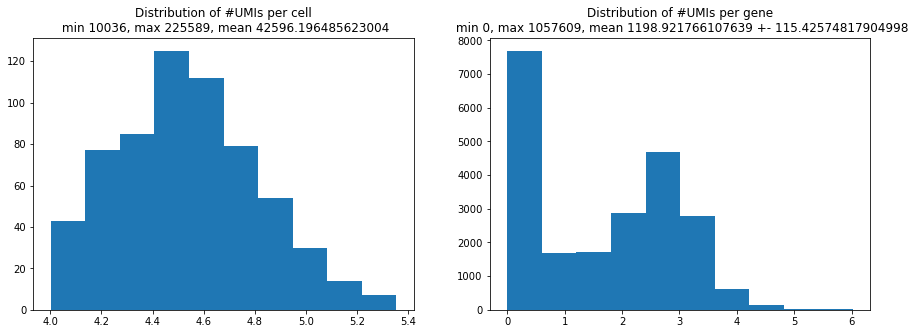

In [26]:
f, ax = plt.subplots(1, 2, figsize=(15, 5))
per_cell_sum = mat.sum(axis=1)
ax[0].hist(np.log10(per_cell_sum+1))
ax[0].set_title('Distribution of #UMIs per cell\n min {}, max {}, mean {}'.format(min(per_cell_sum), max(per_cell_sum), np.mean(per_cell_sum), np.sqrt(np.std(per_cell_sum))));

per_gene_sum = mat.sum(axis=0)
ax[1].hist(np.log10(per_gene_sum+1));
ax[1].set_title('Distribution of #UMIs per gene\n min {}, max {}, mean {} +- {}'.format(min(per_gene_sum), max(per_gene_sum), np.mean(per_gene_sum), np.sqrt(np.std(per_gene_sum))));
plt.show()

Text(0.5, 1.0, 'Distribution of CV, mean 1.4662495368124753 sd 1.0003227369510244')

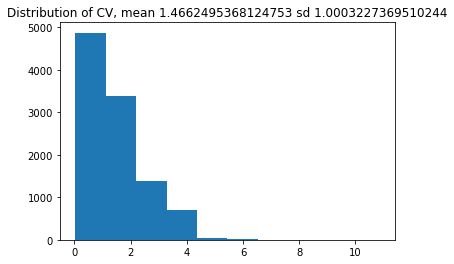

In [27]:
low_expr_thr = 100
high_expr_thr = 1000000
mat = mat[:, (per_gene_sum>=low_expr_thr) & (per_gene_sum<=high_expr_thr)]
mean_exp = mat.mean(axis=0)
std_exp = np.sqrt(mat.std(axis=0))
CV = std_exp/mean_exp
plt.hist(CV)
plt.title('Distribution of CV, mean {} sd {}'.format(np.mean(CV), np.std(CV)**0.5))

(626, 3951)


Text(0.5, 1.0, 'Distribution of #UMIs per gene\n min 100, max 2601, mean 257.64464692482915 +1 11.208466954917885')

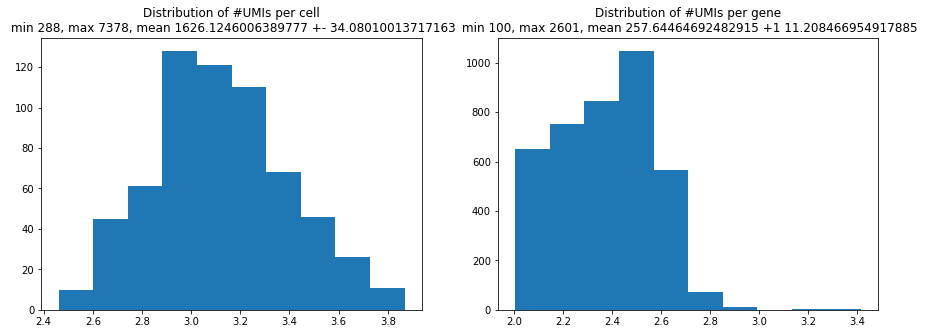

In [28]:
mat = mat[:, CV >= 1.5]
print(mat.shape)
f, ax = plt.subplots(1, 2, figsize=(15, 5))
per_cell_sum = mat.sum(axis = 1)
ax[0].hist(np.log10(per_cell_sum+1))
ax[0].set_title('Distribution of #UMIs per cell\n min {}, max {}, mean {} +- {}'.format(min(per_cell_sum), max(per_cell_sum), np.mean(per_cell_sum), np.sqrt(np.std(per_cell_sum))))

per_gene_sum = mat.sum(axis=0)
ax[1].hist(np.log10(per_gene_sum+1))
ax[1].set_title('Distribution of #UMIs per gene\n min {}, max {}, mean {} +1 {}'.format(min(per_gene_sum), max(per_gene_sum), np.mean(per_gene_sum), np.sqrt(np.std(per_gene_sum))))

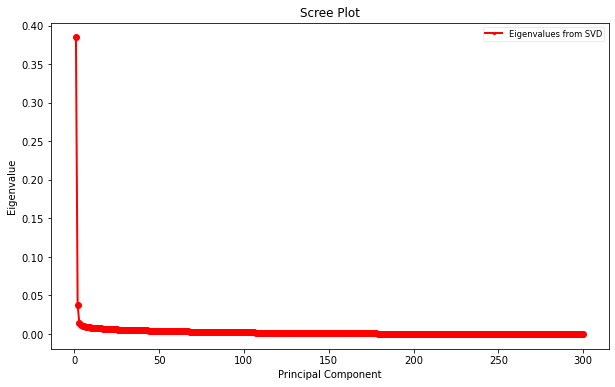

In [29]:
cells_expression = mat.sum(axis=1)
mat = mat[cells_expression>=100, :]
mat = np.log(mat+1)
test = mat[:300, :300]
U, S, V = np.linalg.svd(test) 
eigvals = S**2 / np.sum(S**2)  # NOTE (@amoeba): These are not PCA eigenvalues. 
                               # This question is about SVD.

fig = plt.figure(figsize=(10, 6))
sing_vals = np.arange(len(test)) + 1
plt.plot(sing_vals, eigvals, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
#I don't like the default legend so I typically make mine like below, e.g.
#with smaller fonts and a bit transparent so I do not cover up data, and make
#it moveable by the viewer in case upper-right is a bad place for it 
leg = plt.legend(['Eigenvalues from SVD'], loc='best', borderpad=0.3, 
                 shadow=False, prop=matplotlib.font_manager.FontProperties(size='small'),
                 markerscale=0.4)
leg.get_frame().set_alpha(0.4)
fig.savefig('Zoomed in Scree Plot.png')
#leg.draggable(state=True)

626
{'[12.1942     1.0831449]': 'C_L_BREAST_AAGACTCGTGGTACAG', '[12.522604   1.4811302]': 'C_L_BREAST_ACTGATGGTCAGGTGA', '[14.241143   2.7095938]': 'C_L_BREAST_ATGAGGGAGCTTAAGA', '[12.99062   6.387649]': 'C_L_BREAST_CCGGACACAAGACAAT', '[13.729696  4.622671]': 'C_L_BREAST_CTGCCATCACAATGCT', '[13.660699   2.7546408]': 'C_L_BREAST_TAAGTCGCACCTCGTT', '[14.242507   2.5507627]': 'C_L_BREAST_TCCATCGGTGCTCGTG', '[16.144451    0.21030626]': 'P_SKIN_AAAGAACGTAACAGTA', '[14.618819   2.8587842]': 'P_SKIN_AAATGGAGTATGTCCA', '[15.011115   3.2448304]': 'P_SKIN_AACAAAGGTGTGTTTG', '[16.165247   -0.20412253]': 'P_SKIN_AACAACCTCTGGGCCA', '[13.388934   2.4702618]': 'P_SKIN_AACAGGGCAAGAGGCT', '[12.161244   5.3626633]': 'P_SKIN_AACCTTTGTCGTCATA', '[14.007106   1.4754982]': 'P_SKIN_AACTTCTCATGTCAGT', '[12.927185  4.424934]': 'P_SKIN_AAGACAAAGTTTCTTC', '[15.354471  2.156714]': 'P_SKIN_AAGACTCCAATACCCA', '[14.777739  2.416076]': 'P_SKIN_AAGTACCAGGAAAGGT', '[15.410633   -0.01819969]': 'P_SKIN_AATGAAGAGCGTATGG',

Text(0.5, 1.0, 'Naive Clustering')

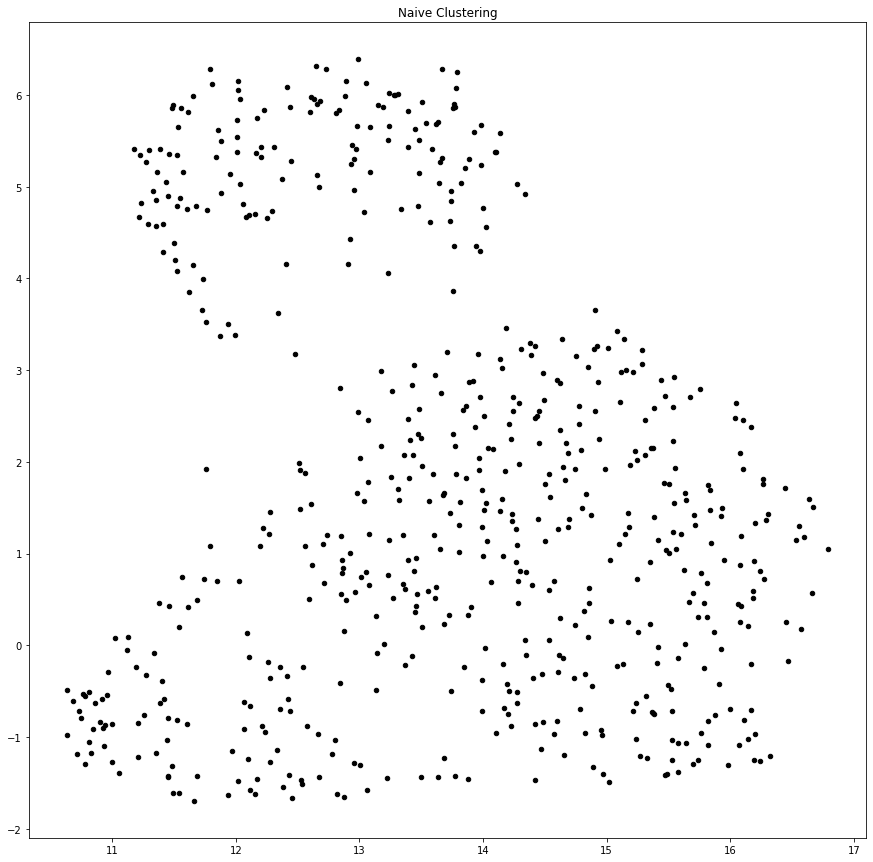

In [31]:
pca = PCA(n_components=100)
pca.fit(mat)
mat_reduce=pca.transform(mat)
true_indices = {}
true_coords = {}
with open('mat_reduce.txt', 'w') as f:
    for i in mat_reduce:
        f.write("%s\n" % i)
embedding = umap.UMAP(n_neighbors=10, min_dist=0.2, metric='euclidean').fit_transform(mat_reduce)
print(len(embedding))
for i in range (0, len(embedding)):
    true_indices.update({str(embedding[i]):cells[i]})
    true_coords.update({cells[i]:embedding[i]})
print(true_indices)
with open('embedding.txt', 'w') as f:
    for e in embedding:
        f.write("%s\n" % e)
plt.figure(figsize=(15, 15))
plt.scatter(embedding[:,0],embedding[:,1], s=20.0, color='black')
plt.title('Naive Clustering')

[3 3 0 2 2 0 0 1 0 0 1 0 2 0 2 0 0 1 2 0 0 1 2 1 0 0 1 2 2 2 1 2 1 1 2 1 0
 2 0 0 0 2 0 1 1 0 0 1 0 2 0 1 1 2 1 2 1 1 1 1 2 2 1 0 2 1 1 2 1 2 2 0 0 1
 0 0 0 1 2 0 0 2 2 1 1 1 1 1 2 0 2 0 2 0 0 1 2 0 2 1 1 0 0 1 0 2 2 0 0 0 0
 1 3 0 0 2 0 0 2 0 1 2 1 1 1 0 2 1 2 2 0 2 1 3 1 1 0 0 0 0 0 2 0 0 0 1 0 0
 2 1 0 1 0 0 0 0 2 0 0 0 0 0 0 1 1 0 2 1 0 0 2 2 1 1 0 0 0 2 1 2 0 0 0 0 0
 1 0 1 0 0 0 1 2 1 2 2 1 1 2 1 1 0 1 2 0 2 0 1 2 0 2 0 0 2 2 0 0 0 2 0 1 1
 2 2 0 1 2 1 2 2 0 1 0 2 2 0 0 0 2 0 1 2 2 2 0 1 2 2 0 0 0 2 0 0 1 0 1 1 2
 1 2 0 0 3 0 0 2 0 3 3 2 1 0 0 2 2 0 0 3 1 2 0 0 0 2 0 0 2 0 1 0 1 0 1 1 1
 0 0 3 3 2 2 0 3 3 2 0 2 1 0 0 2 0 0 0 0 2 2 3 0 2 2 1 0 0 2 1 3 3 1 1 3 1
 0 0 2 0 2 2 3 0 1 1 3 0 0 2 0 0 0 2 2 0 3 0 1 3 3 3 2 3 1 0 0 0 3 0 2 1 0
 1 0 3 0 3 3 3 3 3 3 3 3 3 3 2 3 3 3 3 2 2 3 2 3 3 3 3 1 3 2 2 1 3 1 2 3 3
 0 2 0 0 2 3 3 3 3 3 3 3 3 3 2 2 3 3 3 3 3 3 2 3 3 3 3 3 3 3 2 3 3 3 3 3 3
 3 3 1 3 3 3 1 3 2 2 1 0 2 2 3 3 3 2 2 2 1 3 1 1 2 1 1 3 3 2 1 2 1 3 0 1 3
 1 1 3 3 2 3 1 3 3 2 1 1 

[0 0 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0 0 1 1 1 0 1 0 0 1 0 0
 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 0 0 1 0 1 1 0 0 0
 0 0 0 0 1 0 0 1 1 0 0 0 0 0 1 0 1 0 1 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0
 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 1 0 1 1 0 1 0 2 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 1 1 0 0 1 0 0 0 0 1 0 1 0 0 1 0 1 0 0 1 1 0 0 0 1 0 0 0
 1 1 0 0 1 0 1 1 0 0 0 1 1 0 0 0 1 0 0 1 1 1 0 0 1 1 0 0 0 1 0 0 0 0 0 0 1
 0 1 0 0 2 0 0 1 0 0 0 1 0 0 0 1 1 0 0 2 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 2 1 1 0 2 2 1 0 1 0 0 0 1 0 0 0 0 1 1 0 0 1 1 0 0 0 1 0 0 2 0 0 2 0
 0 0 1 0 1 1 2 0 0 0 2 0 0 1 0 0 0 1 1 0 2 0 0 2 2 2 1 2 0 0 0 0 2 0 1 0 0
 0 0 0 0 2 2 2 2 2 2 2 0 2 2 1 2 0 2 2 1 1 2 1 2 2 2 0 0 2 1 1 0 2 0 1 2 2
 0 1 0 0 1 0 0 2 2 0 2 0 2 0 1 1 2 0 0 2 0 0 1 2 0 2 0 2 2 2 1 2 2 2 2 2 2
 2 2 0 2 2 2 0 2 1 1 0 0 1 1 0 0 0 1 1 1 0 2 0 0 1 0 2 2 2 1 0 1 0 2 0 0 2
 0 0 0 0 1 2 0 2 0 1 0 0 

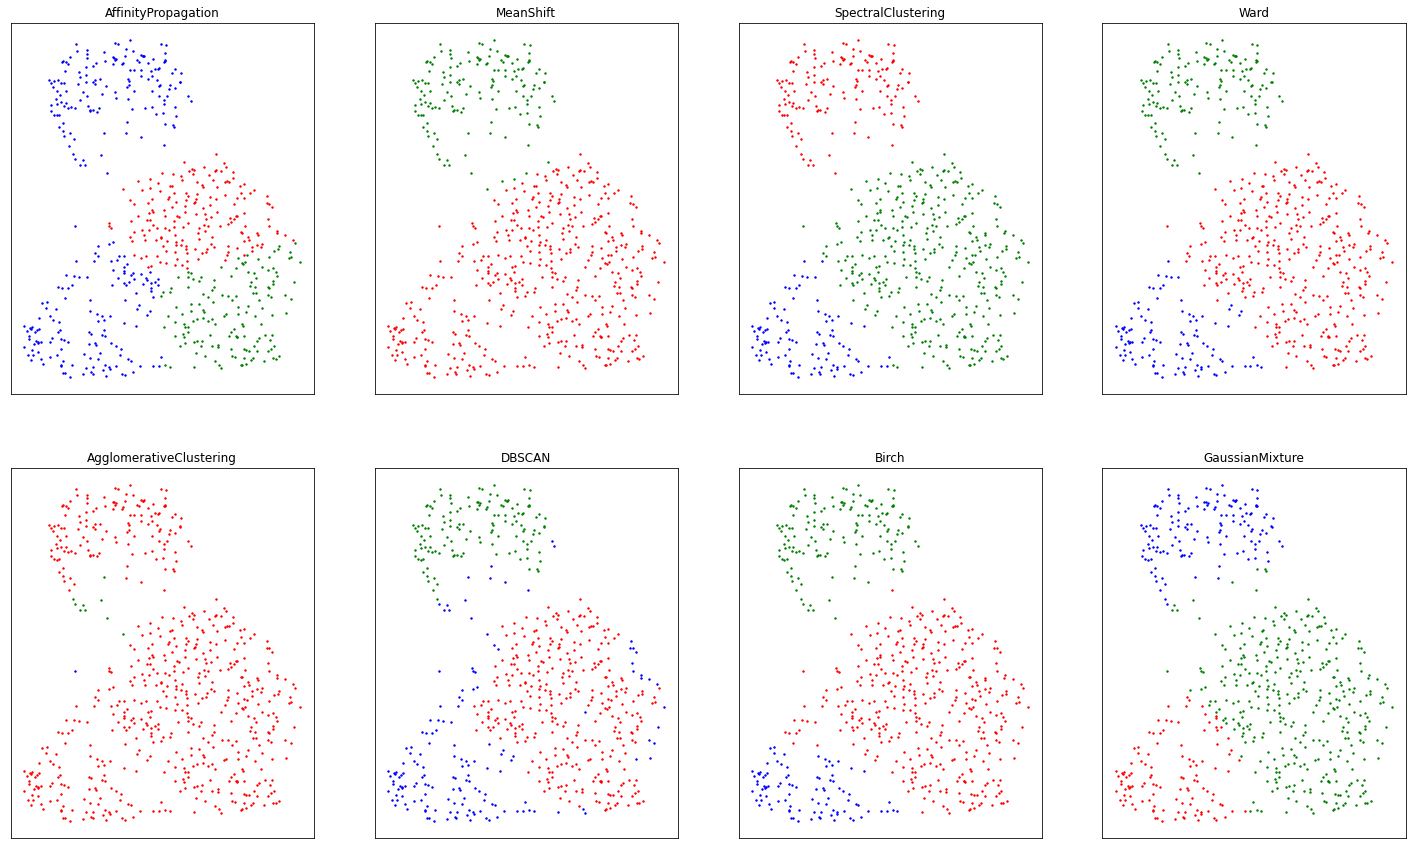

In [32]:
params = {'quantile': .3, 'eps': .3, 'damping': .9, 'preference':-200, 'n_neighbors':10, 'n_clusters':3}
bandwidth = estimate_bandwidth(embedding, quantile=params['quantile'])
connectivity = kneighbors_graph(embedding, n_neighbors=params['n_neighbors'], include_self = False)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ward = AgglomerativeClustering(n_clusters=params['n_clusters'], linkage='ward', connectivity=connectivity)
spectral = SpectralClustering(n_clusters=params['n_clusters'], eigen_solver='arpack', affinity="nearest_neighbors")
dbscan = DBSCAN(eps=params['eps'])
affinity_propagation = AffinityPropagation(damping=params['damping'], preference=params['preference'])
average_linkage = AgglomerativeClustering(linkage="average", affinity="cityblock", n_clusters=params['n_clusters'], connectivity=connectivity)
birch = Birch(n_clusters=params['n_clusters'])
gmm = GaussianMixture(n_components=params['n_clusters'], covariance_type='full')
clustering_algorithms = (
    ('AffinityPropagation', affinity_propagation),
    ('MeanShift', ms),
    ('SpectralClustering', spectral),
    ('Ward', ward),
    ('AgglomerativeClustering', average_linkage),
    ('DBSCAN', dbscan),
    ('Birch', birch),
    ('GaussianMixture', gmm))
#now plot everything
f, ax = plt.subplots(2, 4, figsize=(25,15))
for idx, (name, algorithm) in enumerate(clustering_algorithms):
    algorithm.fit(embedding)
    if hasattr(algorithm, 'labels_'):
        y_pred = algorithm.labels_.astype(np.int)
    else:
        y_pred = algorithm.predict(embedding)
    print(y_pred)
    colors = np.array(list(islice(cycle(['black', 'red', 'green']),
                                    int(max(y_pred) + 1))))
    print(colors)
        # add black color for outliers (if any)
    
    colors = np.append(colors, ["#000000"])
    for i in range(len(embedding)):
        if y_pred[i] == 0:
            color = 'red'
        elif y_pred[i] == 1:
            color = 'green'
        else: 
            color = 'blue'
        ax[idx//4, idx%4].scatter(embedding[i:i+1, 0], embedding[i:i+1, 1], s=2, color=color)
    #ax[idx//4, idx%4].xlim(-2.5, 2.5)
    #ax[idx//4, idx%4].ylim(-2.5, 2.5)
    ax[idx//4, idx%4].set_xticks(())
    ax[idx//4, idx%4].set_yticks(())
    ax[idx//4, idx%4].set_title(name)
    #Store the labels
    if hasattr(algorithm, 'labels_'):
        labels = algorithm.labels_
    else:
        labels = algorithm.predict(embedding)
    #print(labels)
    #Then get the frequency count of the non-negative labels
    counts = np.bincount(labels[labels>=0])
   # print('{}'.format(name))
   # print(counts)
    #print(embedding)
plt.savefig('All Clusters.png')

In [33]:
'''birch.fit(embedding)
birch_coords = {}
y_pred = birch.labels_.astype(np.int)
colors = np.append(colors, ["#000000"])
for i in range(len(embedding)):
    birch_coords.update({str(embedding[i]):y_pred[i]})
    if y_pred[i] == 0:
        color = 'red'
    elif y_pred[i] == 1:
        color = 'green'
    else: 
        color = 'blue'
    plt.scatter(embedding[i-1:i, 0], embedding[i-1:i, 1], s=4, color=color)
print(birch_coords)
true_labels = {}
for i in birch_coords:
    true_labels.update({true_indices[i]:birch_coords[i]})
print(true_labels)'''

def FindTrueLabels(algorithm):
    algorithm_coords = {}
    y_pred = algorithm.labels_.astype(np.int)
    for i in range(len(embedding)):
#         if y_pred[i] == 0:
#             color = 'red'
#         elif y_pred[i] == 1:
#             color = 'green'
#         else: 
#             color = 'blue'
#         plt.scatter(embedding[i:i+1, 0], embedding[i:i+1, 1], s=4, color=color)
        algorithm_coords.update({str(embedding[i]):y_pred[i]})
        
    true_labels = {}
    for i in algorithm_coords:
        true_labels.update({true_indices[i]:algorithm_coords[i]})
    return true_labels

print(FindTrueLabels(birch))

{'C_L_BREAST_AAGACTCGTGGTACAG': 0, 'C_L_BREAST_ACTGATGGTCAGGTGA': 0, 'C_L_BREAST_ATGAGGGAGCTTAAGA': 0, 'C_L_BREAST_CCGGACACAAGACAAT': 1, 'C_L_BREAST_CTGCCATCACAATGCT': 1, 'C_L_BREAST_TAAGTCGCACCTCGTT': 0, 'C_L_BREAST_TCCATCGGTGCTCGTG': 0, 'P_SKIN_AAAGAACGTAACAGTA': 0, 'P_SKIN_AAATGGAGTATGTCCA': 0, 'P_SKIN_AACAAAGGTGTGTTTG': 0, 'P_SKIN_AACAACCTCTGGGCCA': 0, 'P_SKIN_AACAGGGCAAGAGGCT': 0, 'P_SKIN_AACCTTTGTCGTCATA': 1, 'P_SKIN_AACTTCTCATGTCAGT': 0, 'P_SKIN_AAGACAAAGTTTCTTC': 1, 'P_SKIN_AAGACTCCAATACCCA': 0, 'P_SKIN_AAGTACCAGGAAAGGT': 0, 'P_SKIN_AATGAAGAGCGTATGG': 0, 'P_SKIN_AATGAAGCACAAATAG': 1, 'P_SKIN_AATGAAGGTAGGACCA': 0, 'P_SKIN_AATGCCAGTTCTAACG': 0, 'P_SKIN_ACAAAGAGTTACAGCT': 0, 'P_SKIN_ACATCCCCAATTTCGG': 1, 'P_SKIN_ACCCTTGGTCTGCGCA': 0, 'P_SKIN_ACCTACCAGCAACAAT': 0, 'P_SKIN_ACCTACCCAATAAGGT': 0, 'P_SKIN_ACGATGTGTCATCGGC': 0, 'P_SKIN_ACGGTCGGTGCTCGTG': 1, 'P_SKIN_ACGTAGTAGCCGTAAG': 1, 'P_SKIN_ACTACGAAGGAACATT': 1, 'P_SKIN_ACTATTCAGATCGACG': 0, 'P_SKIN_ACTGATGGTTGAAGTA': 1, 'P_SKIN_ACT

In [34]:
def ClusterIndicesNumpy(clustNum, labels_array): #numpy 
    return np.where(labels_array == clustNum)[0]

def ClusterIndicesComp(clustNum, labels_array): #list comprehension
    return np.array([i for i, x in enumerate(labels_array) if x == clustNum])

In [40]:
import json
def DataCollection(algorithm, cluster_1, cluster_2, cluster_3, results):
    
    labels = FindTrueLabels(algorithm)
    
    num1 = []
    num2 = []
    num3 = []
    
#     num1 = ClusterIndicesNumpy(0, algorithm.labels_)
#     num2 = ClusterIndicesNumpy(1, algorithm.labels_)
#     num3 = ClusterIndicesNumpy(2, algorithm.labels_) 
    barcodes1 = {}
    barcodes2 = {}
    barcodes3 = {}
    DataCollection.truthnum1 = {}
    for i in labels:
        if labels[i] == 0:
            barcodes1.update({i:labels[i]})
        elif labels[i] == 1:
            barcodes2.update({i:labels[i]})
        else:
            barcodes3.update({i:labels[i]})
        
        
#     for i in num1:
#         barcodes1.update({cells[i]:i})
#     for i in num2:
#         barcodes2.update({cells[i]:i})
#     for i in num3:
#         barcodes3.update({cells[i]:i})
    with open(cluster_1, 'w') as filehandle:
        for listitem in barcodes1:
            filehandle.write('%s\n' % listitem)
    with open(cluster_2, 'w') as filehandle:
        for listitem in barcodes2:
            filehandle.write('%s\n' % listitem)
    with open(cluster_3, 'w') as filehandle:
        for listitem in barcodes3:
            filehandle.write('%s\n' % listitem)
        
        
    g1 = open('G1Cells.txt').readlines()
    g1_line = []
    for lines in g1:
        g1_line.append(lines)
    g2m = open('G2MCells.txt').readlines()
    g2m_line = []
    for lines in g2m:
        g2m_line.append(lines)
    s = open('SCells.txt').readlines()
    s_line = []

    res = open(results, "w")

    g1count = 0
    g2mcount = 0
    scount = 0

    g1count2 = 0
    g2mcount2 = 0
    scount2 = 0

    g1count3 = 0
    g2mcount3 = 0
    scount3 = 0
    
    x = 0
    y = 0
    z = 0

    for lines in s:
        s_line.append(lines)
    cluster1 = open(cluster_1).readlines()
    cluster1_line = []
    for lines in cluster1:
        cluster1_line.append(lines)
    for i in cluster1_line:
        for j in g1_line:
            if i == j:
                g1count = g1count + 1
                DataCollection.truthnum1.update({true_coords[i[0:len(i)-1]]:'red'})
                #DataCollection.truthnum1.update({(barcodes1[i]):'black'})
    res.write("G1 Count Cluster 1: \n")
    res.write(str(g1count/(len(cluster1_line))) + " \n")
    res.write(str(g1count) + " \n")
    for i in cluster1_line:
        for j in g2m_line:
            if i == j:
                g2mcount = g2mcount + 1
                DataCollection.truthnum1.update({str(true_coords[i[0:len(i)-1]]):'black'})
                #DataCollection.truthnum1.update({(barcodes1[i]):'red'})
    res.write("G2M Count Cluster 1: \n")
    res.write(str(g2mcount/(len(cluster1_line))) + "\n")
    res.write(str(g2mcount) + "\n")
    for i in cluster1_line:
        for j in s_line:
            if i == j:
                scount = scount + 1
                DataCollection.truthnum1.update({true_coords[i[0:len(i-1)]]:'red'})
                #DataCollection.truthnum1.update({(barcodes1[i]):'red'})
    res.write("S Count Cluster 1: \n")
    res.write(str(scount/(len(cluster1_line))) + "\n")
    res.write(str(scount) + "\n")
    res.write("\n")

    cluster2 = open(cluster_2).readlines()
    cluster2_line = []
    for lines in cluster2:
        cluster2_line.append(lines)
    for i in cluster2_line:
        for j in g1_line:
            if i == j:
                g1count2 = g1count2 + 1
                DataCollection.truthnum1.update({true_coords[i[0:len(i-1)]]:'red'})
                #DataCollection.truthnum1.update({(barcodes2[i]):'red'})
    res.write("G1 Count Cluster 2:" + "\n")
    res.write(str(g1count2/(len(cluster2_line))) + "\n")
    res.write(str(g1count2) + "\n")
    for i in cluster2_line:
        for j in g2m_line:
            if i == j:
                g2mcount2 = g2mcount2 + 1
                DataCollection.truthnum1.update({true_coords[i[0:len(i-1)]]:'black'})
                #DataCollection.truthnum1.update({(barcodes2[i]):'black'})
    res.write("G2M Count Cluster 2:" + "\n")
    res.write(str(g2mcount2/(len(cluster2_line))) + "\n")
    res.write(str(g2mcount2) + "\n")
    for i in cluster2_line:
        for j in s_line:
            if i == j:
                scount2 = scount2 + 1
                DataCollection.truthnum1.update({true_coords[i[0:len(i-1)]]:'red'})
                #DataCollection.truthnum1.update({(barcodes2[i]):'red'})
    res.write("S Count Cluster 2: \n")
    res.write(str(scount2/(len(cluster2_line))) + "\n")
    res.write(str(scount2) + "\n")
    res.write("\n")

    cluster3 = open(cluster_3).readlines()
    cluster3_line = []
    for lines in cluster3:
        cluster3_line.append(lines)
    for i in cluster3_line:
        for j in g1_line:
            if i == j:
                g1count3 = g1count3 + 1
                DataCollection.truthnum1.update({true_coords[i[0:len(i-1)]]:'red'})
                #DataCollection.truthnum1.update({(barcodes3[i]):'red'})
    res.write("G1 Count Cluster 3:" + "\n")
    res.write(str(g1count3/(len(cluster3_line))) + "\n")
    res.write(str(g1count3) + "\n")
    for i in cluster3_line:
        for j in g2m_line:
            if i == j:
                g2mcount3 = g2mcount3 + 1
                DataCollection.truthnum1.update({true_coords[i[0:len(i-1)]]:'red'})
                #DataCollection.truthnum1.update({(barcodes3[i]):'red'})
    res.write("G2M Count Cluster 3:" + "\n")
    res.write(str(g2mcount3/(len(cluster3_line))) + "\n")
    res.write(str(g2mcount3) + "\n")
    for i in cluster3_line:
        for j in s_line:
            if i == j:
                scount3 = scount3 + 1
                DataCollection.truthnum1.update({true_coords[i[0:len(i-1)]]:'black'})
                #DataCollection.truthnum1.update({(barcodes3[i]):'black'})
    res.write("S Count Cluster 3:" + "\n")
    res.write(str(scount3/(len(cluster3_line))) + "\n")
    res.write(str(scount3) + "\n")
    res.write("\n")
    res.write(json.dumps(DataCollection.truthnum1))
    res.write("")
DataCollection(spectral, 'spectral_cluster1.txt', 'spectral_cluster2.txt', 'spectral_cluster3.txt', 'spectral_results.txt')
DataCollection(birch, 'birch_cluster1.txt', 'birch_cluster2.txt', 'birch_cluster3.txt', 'birch_results.txt')
DataCollection(affinity_propagation,'ap_cluster1.txt', 'ap_cluster2.txt', 'ap_cluster3.txt', 'ap_results.txt')
DataCollection(ward, 'waard_cluster1.txt', 'waard_cluster2.txt', 'waard_cluster3.txt', 'waard_results.txt')

TypeError: unsupported operand type(s) for -: 'str' and 'int'

{'C_L_BREAST_ATGAGGGAGCTTAAGA\n': 'black', 'P_SKIN_AAAGAACGTAACAGTA\n': 'black', 'P_SKIN_AACAAAGGTGTGTTTG\n': 'black', 'P_SKIN_AACAACCTCTGGGCCA\n': 'black', 'P_SKIN_AACAGGGCAAGAGGCT\n': 'black', 'P_SKIN_AACTTCTCATGTCAGT\n': 'black', 'P_SKIN_AAGACTCCAATACCCA\n': 'black', 'P_SKIN_AAGTACCAGGAAAGGT\n': 'black', 'P_SKIN_AATGAAGAGCGTATGG\n': 'black', 'P_SKIN_ACAAAGAGTTACAGCT\n': 'black', 'P_SKIN_ACCCTTGGTCTGCGCA\n': 'black', 'P_SKIN_ACCTACCAGCAACAAT\n': 'black', 'P_SKIN_ACGATGTGTCATCGGC\n': 'black', 'P_SKIN_ACTGTGAGTAGAAACT\n': 'black', 'P_SKIN_ACTTCCGTCTTGATTC\n': 'black', 'P_SKIN_AGACAGGAGTTGGCGA\n': 'black', 'P_SKIN_AGATCGTGTGTGTACT\n': 'black', 'P_SKIN_AGATGAATCCTTTAGT\n': 'black', 'P_SKIN_AGCGCTGGTTGTTGAC\n': 'black', 'P_SKIN_AGGGCCTGTAGCTGTT\n': 'black', 'P_SKIN_AGGTCTAAGACTACGG\n': 'black', 'P_SKIN_AGTGTTGTCTCACCCA\n': 'black', 'P_SKIN_ATCAGGTCAGCTACTA\n': 'black', 'P_SKIN_ATCGGATGTCCTGGTG\n': 'black', 'P_SKIN_ATGCATGCAATGGGTG\n': 'black', 'P_SKIN_ATTCAGGAGTCTTGGT\n': 'black', 'P_SKIN

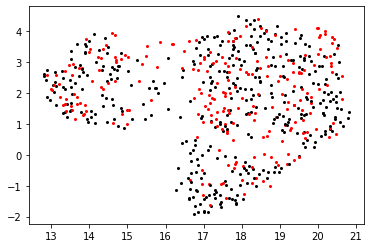

In [23]:
coloring = []
print(DataCollection.truthnum1)
DataCollection(spectral, 'spectral_cluster1.txt', 'spectral_cluster2.txt', 'spectral_cluster3.txt', 'spectral_results.txt')
for i in DataCollection.truthnum1:
    coloring.append(DataCollection.truthnum1[i])
for i in range(len(DataCollection.truthnum1)):
    plt.scatter(embedding[i:i+1, 0], embedding[i:i+1, 1], s=4, color=coloring[i])
labels = ward.labels_
plt.savefig('Spectral Truth Plot.png')